# The Baseline New Keynesian Model
This notebook provides a solution of the baseline new Keynesian DSGE model, as described in Galí (2015), Chapter 3, and reproduces the IRFs provided therein. The solution method is due to Sims (2000), and the implementation is provided by the NY Fed's DSGE.jl Julia package.


The linearised model can be written as a system of linear rational-expectations stochastic difference equations in the following variables:
- $\hat \lambda_t$: The Lagrange multiplier associated with the household's budget constraint.
- $\hat c_t$: Household consumption.
- $\hat w_t$: The real wage rate.
- $\hat \pi_t^*$: The optimal relative price set by firms.
- $\hat \pi_t$: The net inflation rate.
- $\hat R_t$: The nominal net interest rate on a one period nominal bond.
- $\hat q_t$: The price of a one period nominal bond.
- $\hat r_t$: The real net interest rate on a one period nominal bond.
- $\hat l_t$: The labour supply.
- $\hat y_t$: Total output.
- $\hat y_t^n$: Natural output.
- $\hat y_t^g$: The output gap.
- $\widehat {mc}_t$: The marginal cost.
- $\hat p_t$: The price level.
- $\hat a_t$: Total factor productivity.
- $\hat v_t$: Monetary policy tightness.
- $\hat z_t$: Discount factor shock.
- $\hat x_t^n$: Auxiliary price setting variable 1.
- $\hat x_t^d$: Auxiliary price setting variable 2.

All variables are expressed in logged deviations from the steady state value of the original variable.

The exogenous parameters are:
- $\sigma$: Coefficient of relative risk aversion.
- $\beta$: Household discount factor.
- $\varphi$: Inverse Frisch elasticity of substitution.
- $\varepsilon$: Elasticity of substitution between inputs.
- $\theta$: Calvo parameter.
- $\varphi_\pi$: Coefficient on inflation in the Taylor rule.
- $\varphi_y$: Coefficient on the output (either the gap or deviation of output from the steady state) in the Taylor rule.
- $\alpha$: Labour share of output.
- $\mu$: Steady state markup.
- $\rho_a$: Productivity shock persistence.
- $\rho_v$: Monetary policy shock persistence.
- $\rho_z$: Preference shock persistence.

In [7]:
using LinearAlgebra
using DSGE
using Plots

##################################################################################################################################
# 1. Declare parameters
##################################################################################################################################

# Coefficient of relative risk aversion
σ = 1

# Discount factor
β = 0.99

# Inverse Frisch elasticity of substitution
φ = 5

# Elasticity of substitution between goods/inputs 
ε = 9

# Calvo parameter
θ = 0.75

# Taylor rule inflation response coefficient
φ_π = 1.5

# Taylor rule output gap (/output deviation from steady state) response coefficient
φ_y = 0.125

# Labour share of output
α = 0.25

# Steady state markup
μ = ε / (ε - 1)

# Productivity shock persistence
ρ_a = 0.9

# Monetary policy shock persistence
ρ_v = 0.5

# Preference shock persistence
ρ_z = 0.5

# Steady state variables used in linearised equations
R_ss = 1 / β
mc_ss = 1 / μ
l_ss = ((1 - α) * mc_ss)^(1 / ((1 - σ) * α + φ + σ))
y_ss = l_ss^(1-α)
λ_ss = y_ss^(-σ)
xn_ss = (λ_ss * mc_ss * y_ss) / (1 - β * θ)
xd_ss = (λ_ss * y_ss) / (1 - β * θ);

The model equations are:

\begin{align*}
& \hat \lambda_t = \hat z_t - \sigma \hat c_t && (\text{Household marginal utility}) \\
& \hat q_t = \mathbb E_t[\hat \lambda_{t+1}]-\hat \lambda_t - \mathbb E_t[\hat \pi_{t+1}] && (\text{Euler equation}) \\
& \hat w_t = \hat z_t + \varphi \hat l_t - \hat \lambda_t && (\text{Labour supply}) \\
& \left(1 + \frac{\varepsilon \alpha}{1 - \alpha}\right)\hat \pi_t^* = \hat x_t^n - \hat x_t^d && (\text{Optimal reset price}) \\
& X^n \hat x_t^n = \Lambda Y MC(\hat \lambda_t + \hat y_t + \widehat{mc}_t) + \beta \theta X^n \left[\left(\varepsilon +
\frac{\varepsilon \alpha}{1-\alpha}\right) \mathbb E_t[\hat \pi_{t+1}] + \mathbb E_t[\hat x_{t+1}^n]\right] && (\text{Price setting auxiliary equation 1}) \\
& X^d \hat x_t^d = \Lambda Y (\hat \lambda _t + \hat y_t) + \beta \theta X^d \left[
(\varepsilon - 1)\mathbb E_t [\hat \pi_{t+1}] + \mathbb E_t [\hat x_{t+1}^d]\right] && (\text{Price setting auxiliary equation 2}) \\
& \hat \pi_t^* = \frac \theta{1-\theta} \hat \pi_t && (\text{Price level LOM}) \\
& \hat R_t = \phi_\pi \hat \pi_t + \phi_y \hat y_t^g + \hat v_t && (\text{Monetary policy}) \\
& \hat R_t = - \hat q_t && (\text{Gross return definition}) \\
& \hat r_t = \hat R_t - \mathbb E_t [\hat \pi_{t+1}] && (\text{Real interest rate}) \\
& \hat y_t = \hat a_t + (1-\alpha) \hat l_t && (\text{Aggregate output}) \\
& \hat c_t =\hat y_t && (\text{Market clearing}) \\
& \hat y_t^n = \frac{1+\varphi}{\sigma(1-\alpha) + \alpha + \varphi}\hat a_t && (\text{Natural output}) \\
& \hat y_t^g =\hat y_t - \hat y_t^n && (\text{Output gap}) \\
& \widehat{mc}_t = \hat w_t +\frac{\alpha}{1-\alpha} \hat y_t - \frac 1{1-\alpha}\hat a_t && (\text{Marginal cost}) \\
& \pi_t = p_t - p_{t-1} && (\text{Inflation/price level relation}) \\
& \hat a_t = \rho_a \hat a_{t-1}+\varepsilon_{a, t} && (\text{Technology shock process}) \\
& \hat v_t = \rho_v \hat v_{t-1}+\varepsilon_{v, t} && (\text{Monetary policy shock process}) \\
& \hat z_t = \rho_z \hat z_{t-1} + \varepsilon_{z, t} && (\text{Preference shock process})
\end{align*}

where upper case letters denote steady state values of the corresponding variables. In Gali's text, the monetary policy rule replaces $y_t^g$ with the deviation of output from its steady state value.

## Model Solution
The model equations can be written more compactly using matrix notation as:
$$\Gamma_0 s_t = \Gamma_1 s_{t-1} + C + \Psi \varepsilon_t + \Pi \eta_t$$
where:
- $s_t$ denotes the vector of endogenous model variables, which includes all the variables listed above at time $t$ and their expected value at time $t+1$.
- $\varepsilon_t$ denotes the vector of exogenous shocks, which includes $\{\varepsilon_{k,t}: k = a, v, z\}$.
- $\eta_t$ denotes the vector of expectational errors, and includes the expectational error associated with each variable whose expected value at time $t+1$ appears in the model equations, defined by $\eta_{x, t} = \mathbb E_{t-1}[x_t] - x_t$ for any variable $x_t$.
- $\Gamma_0$, $\Gamma_1$, $C$, $\Psi$, and $\Pi$ are defined in terms of the exogenous parameters in accordance with the model equations.

In [8]:
##################################################################################################################################
# 2. Set up matrices Γ0. Γ1, C, Ψ, Π corresponding with the canonical Sims form:
# Γ0 s_t = Γ1 s_{t-1} + C + Ψ ε_t + Π η_t
##################################################################################################################################

s = ("λ", "λp1", "c", "w", "πstar", "xn", "xnp1", "xd", "xdp1", "π", "πp1", "R", "q", "r", "l", "y", "yn", "yg", "mc", "p", "a", "v", "z")

# Initialise matrices to zero. We'll populate them equation by equation.
Γ0 = zeros(Float64, 23, 23)
Γ1 = zeros(Float64, 23, 23)
C = zeros(Float64, 23)
Ψ = zeros(Float64, 23, 3)
Π = zeros(Float64, 23, 4)

# Equation 1: Lagrange multiplier definition
Γ0_λ_1 = 1
Γ0_z_1 = -1
Γ0_c_1 = σ

Γ0[1, 1] = Γ0_λ_1
Γ0[1, 23] = Γ0_z_1
Γ0[1, 3] = Γ0_c_1

# Equation 2: Euler equation
Γ0_q_2 = 1
Γ0_λp1_2 = -1
Γ0_λ_2 = 1
Γ0_πp1_2 = 1

Γ0[2, 13] = Γ0_q_2
Γ0[2, 2] = Γ0_λp1_2
Γ0[2, 1] = Γ0_λ_2
Γ0[2, 11] = Γ0_πp1_2

# Equation 3: Labour supply
Γ0_w_3 = 1
Γ0_z_3 = -1
Γ0_l_3 = -φ
Γ0_λ_3 = 1

Γ0[3, 4] = Γ0_w_3
Γ0[3, 23] = Γ0_z_3
Γ0[3, 15] = Γ0_l_3
Γ0[3, 1] = Γ0_λ_3

# Equation 4: Price setting
Γ0_πstar_4 = (1 + ((ε * α) / (1 - α)))
Γ0_xn_4 = -1
Γ0_xd_4 = 1

Γ0[4, 5] = Γ0_πstar_4
Γ0[4, 6] = Γ0_xn_4
Γ0[4, 8] = Γ0_xd_4

# Equation 5: Price setting numerator recursion
Γ0_xn_5 = xn_ss
Γ0_λ_5 = -λ_ss * y_ss * mc_ss
Γ0_y_5 = -λ_ss * y_ss * mc_ss
Γ0_mc_5 = -λ_ss * y_ss * mc_ss
Γ0_πp1_5 = -β * θ * xn_ss * (ε + ((ε * α) / (1 - α)))
Γ0_xnp1_5 = -β * θ * xn_ss

Γ0[5, 6] = Γ0_xn_5
Γ0[5, 1] = Γ0_λ_5
Γ0[5, 16] = Γ0_y_5
Γ0[5, 19] = Γ0_mc_5
Γ0[5, 11] = Γ0_πp1_5
Γ0[5, 7] = Γ0_xnp1_5

# Equation 6: Price setting denominator recursion
Γ0_xd_6 = xd_ss
Γ0_λ_6 = -λ_ss * y_ss
Γ0_y_6 = -λ_ss * y_ss
Γ0_πp1_6 = -β * θ * xd_ss * (ε - 1)
Γ0_xdp1_6 = -β * θ * xd_ss

Γ0[6, 8] = Γ0_xd_6
Γ0[6, 1] = Γ0_λ_6
Γ0[6, 16] = Γ0_y_6
Γ0[6, 11] = Γ0_πp1_6
Γ0[6, 9] = Γ0_xdp1_6

# Equation 7: Price level LOM
Γ0_πstar_7 = 1
Γ0_π_7 = -θ/(1 - θ)

Γ0[7, 5] = Γ0_πstar_7
Γ0[7, 10] = Γ0_π_7

# Equation 8: Monetary policy rule
Γ0_R_8 = 1
Γ0_π_8 = -φ_π
#Γ0_yg_8 = -φ_y         # Standard rule: CB responds to output gap
Γ0_y_8 = -φ_y           # Galí rule: CB responds to output deviations from steady state
Γ0_v_8 = -1

Γ0[8, 12] = Γ0_R_8
Γ0[8, 10] = Γ0_π_8
#Γ0[8, 18] = Γ0_yg_8    # Standard rule
Γ0[8, 16] = Γ0_y_8      # Galí rule
Γ0[8, 22] = Γ0_v_8

# Equation 9: Nominal rate definition
Γ0_R_9 = 1
Γ0_q_9 = 1

Γ0[9, 12] = Γ0_R_9
Γ0[9, 13] = Γ0_q_9

# Equation 10: Real rate Fisher relation
Γ0_r_10 = 1
Γ0_R_10 = -1
Γ0_πp1_10 = 1

Γ0[10, 14] = Γ0_r_10
Γ0[10, 12] = Γ0_R_10
Γ0[10, 11] = Γ0_πp1_10

# Equation 11: Aggregate output
Γ0_y_11 = 1
Γ0_a_11 = -1
Γ0_l_11 = α - 1

Γ0[11, 16] = Γ0_y_11
Γ0[11, 21] = Γ0_a_11
Γ0[11, 15] = Γ0_l_11

# Equation 12: Market clearing
Γ0_c_12 = 1
Γ0_y_12 = -1

Γ0[12, 3] = Γ0_c_12
Γ0[12, 16] = Γ0_y_12

# Equation 13: Natural output
Γ0_yn_13 = 1
Γ0_a_13 = -(1 + φ) / (σ * (1 - α) + α + φ)

Γ0[13, 17] = Γ0_yn_13
Γ0[13, 21] = Γ0_a_13

# Equation 14: Output gap definition
Γ0_yg_14 = 1
Γ0_y_14 = -1
Γ0_yn_14 = 1

Γ0[14, 18] = Γ0_yg_14
Γ0[14, 16] = Γ0_y_14
Γ0[14, 17] = Γ0_yn_14

# Equation 15: Marginal cost
Γ0_mc_15 = 1
Γ0_w_15 = -1
Γ0_y_15 = -α / (1 - α)
Γ0_a_15 = 1 / (1 - α)

Γ0[15, 19] = Γ0_mc_15
Γ0[15, 4] = Γ0_w_15
Γ0[15, 16] = Γ0_y_15
Γ0[15, 21] = Γ0_a_15

# Equation 16: Inflation/price level relation
Γ0_π_16 = 1
Γ0_p_16 = -1

Γ0[16, 10] = Γ0_π_16
Γ0[16, 20] = Γ0_p_16

Γ1_p_16 = -1

Γ1[16, 20] = Γ1_p_16

# Equation 17: Technology shock process
Γ0_a_17 = 1

Γ0[17, 21] = Γ0_a_17

Γ1_a_17 = ρ_a

Γ1[17, 21] = Γ1_a_17

Ψ_eps_a_17 = 1

Ψ[17, 1] = Ψ_eps_a_17

# Equation 18: Monetary policy shock process
Γ0_v_18 = 1

Γ0[18, 22] = Γ0_v_18

Γ1_v_18 = ρ_v

Γ1[18, 22] = Γ1_v_18

Ψ_eps_v_18 = 1

Ψ[18, 2] = Ψ_eps_v_18

# Equation 19: Preference shock process
Γ0_z_19 = 1

Γ0[19, 23] = Γ0_z_19

Γ1_z_19 = ρ_z

Γ1[19, 23] = Γ1_z_19

Ψ_eps_z_19 = 1

Ψ[19, 3] = Ψ_eps_z_19

# Equation 20: λ expectational error
Γ0_λ_20 = 1

Γ0[20, 1] = Γ0_λ_20

Γ1_λp1_20 = 1

Γ1[20, 2] = Γ1_λp1_20

Π_λ_20 = 1
Π[20, 1] = Π_λ_20

# Equation 21: π expectational error
Γ0_π_21 = 1

Γ0[21, 10] = Γ0_π_21

Γ1_πp1_21 = 1

Γ1[21, 11] = Γ1_πp1_21

Π_π_21 = 1
Π[21, 2] = Π_π_21

# Equation 22: xn expectational error
Γ0_xn_22 = 1

Γ0[22, 6] = Γ0_xn_22

Γ1_xnp1_22 = 1

Γ1[22, 7] = Γ1_xnp1_22

Π_xn_22 = 1
Π[22, 3] = Π_xn_22

# Equation 23: xd expectational error
Γ0_xd_23 = 1

Γ0[23, 8] = Γ0_xd_23

Γ1_xdp1_23 = 1

Γ1[23, 9] = Γ1_xdp1_23

Π_xd_23 = 1
Π[23, 4] = Π_xd_23;

The model solution consists of the transition equation that determines the values of the endogenous variables at time $t$ as a function of their values at time $t-1$ and the exogenous shocks, and can be written as:
$$s_t = T s_{t-1} + R \varepsilon_t + C$$

The solution method described by Sims takes as inputs the matrices $\Gamma_0$, $\Gamma_1$, $C$, $\Psi$, and $\Pi$, and returns the matrices in the transition equation, $T$, $R$, and $C$.

In [9]:
##################################################################################################################################
# 3. Solve the system for the matrices T, R in the transition equation
# s_t = T s_{t-1} + R ε_t + C
##################################################################################################################################

sol = DSGE.gensys(Γ0, Γ1, C, Ψ, Π)
T = sol[1];
R = sol[3];

## Computing the IRFs
The impulse response function corresponding with a shock $\varepsilon_0 = \bar \varepsilon_0$ is a map from $\mathbb Z_+$ to $\mathbb R_+$ that determines the value of the endogenous variables for the periods following the shocks. The IRFs measure the change in the variable relative to a counterfactual scenario in which the shock does not occur, and can be interpreted as the causal response of the variable to the shock. To compute them, we set the the exogenous shocks to some prespecified value, then compute the endogenous variables according to the transition equation, beginning with an initial value for the endogenous variables of zero.

The impulse responses corresponding with a shock corresponding to an exogenous change in technology, monetary policy, and the discount rate, respectively, are computed and plotted.

In [16]:
##################################################################################################################################
# 4. Set shocks
##################################################################################################################################
function set_shocks(eps_a, eps_v, eps_z)
    return [
        eps_a;
        eps_v;
        eps_z
    ]
end

##################################################################################################################################
# 5. Generate impulse responses
##################################################################################################################################
function compute_IRFs(shocks, periods)
    # Calculate initial responses to the shocks
    # s_{-1} = 0 by construction, so s_0 = R ε_1
    s = [R * shocks]

    # Calculate future values of the endogenous variables
    # ε_κ = 0 for k > 0, so s_t = T s_{t-1} for t > 0
    for k in 2:15
        s_next = T * s[k - 1]
        push!(s, s_next)
    end

    return s
end

periods = 15

##################################################################################################################################
# 6. 
##################################################################################################################################

shocks_tfp = set_shocks(1, 0, 0)
shocks_monetary_policy = set_shocks(0, 0.25, 0)
shocks_discount_rate = set_shocks(0, 0, -0.5)

# s = compute_IRFs(shocks_tfp, periods)

##################################################################################################################################
# 6. Plot IRFs
##################################################################################################################################

function format_plot(series, series_name, legend_position)
    plot(1:periods, series, label = "", title = series_name, grid = false, markershape = :circle, markersize = 2.5, markerstrokewidth = 0, legend = legend_position)
end

function plot_irfs(s)
    y = []
    yg = []
    π = []
    l = []
    w = []
    p = []
    R = []
    mc = []
    r = []
    a = []
    v = []
    z = []

    for k in 1:periods
        push!(y, s[k][16])
        push!(yg, s[k][18])
        push!(l, s[k][15])
        push!(w, s[k][4])
        push!(p, s[k][20])
        push!(mc, s[k][19])
        push!(π, s[k][10] * 4)
        push!(R, s[k][12] * 4)
        push!(r, s[k][14] * 4)
        push!(a, s[k][21])
        push!(v, s[k][22])
        push!(z, s[k][23])
    end

    yg_irf = format_plot(yg, "Output gap", :topright)
    π_irf = format_plot(π, "Inflation", :bottomright)
    y_irf = format_plot(y, "Output", :bottomright)
    l_irf = format_plot(l, "Employment", :bottomright)
    w_irf = format_plot(w, "Real wage", :bottomright)
    p_irf = format_plot(p, "Price level", :bottomright)
    mc_irf = format_plot(mc, "Marginal cost", :bottomright)
    a_irf = format_plot(a, "Productivity", :topright)
    v_irf = format_plot(v, "Monetary policy shock", :topright)
    z_irf = format_plot(z, "Preference shock", :bottomright)

    if !isapprox(s[1][21], 0.0; atol=eps(Float64), rtol=0)
        plt = plot(yg_irf, π_irf, y_irf, l_irf, w_irf, p_irf, mc_irf, a_irf, layout = @layout([a b c d; e f g h]), size = (1345, 600))
        display(plt)
    elseif !isapprox(s[1][22], 0.0; atol=eps(Float64), rtol=0)
        plt = plot(yg_irf, π_irf, y_irf, l_irf, w_irf, p_irf, mc_irf, v_irf, layout = @layout([a b c d; e f g h]), size = (1345, 600))
        display(plt)
    elseif !isapprox(s[1][23], 0.0; atol=eps(Float64), rtol=0)
        plt = plot(yg_irf, π_irf, y_irf, l_irf, w_irf, p_irf, mc_irf, z_irf, layout = @layout([a b c d; e f g h]), size = (1345, 600))
        display(plt)
    end
end;

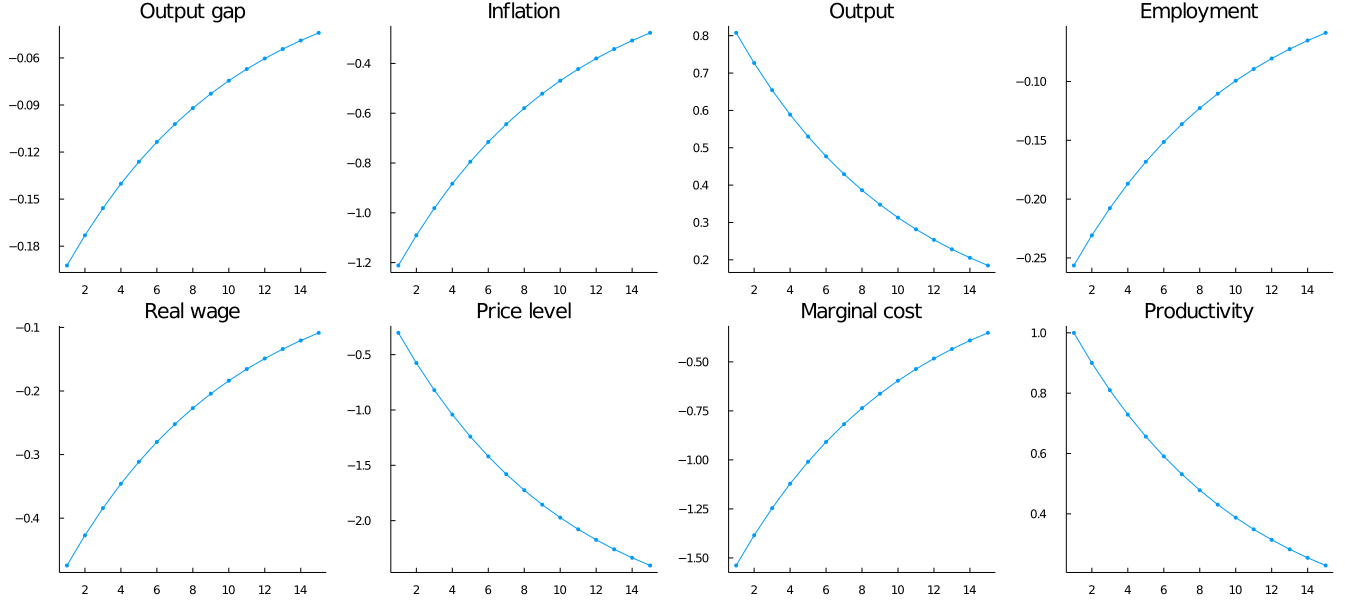

In [11]:
# Display the plots for a TFP shock
plot_irfs(compute_IRFs(shocks_tfp, periods))

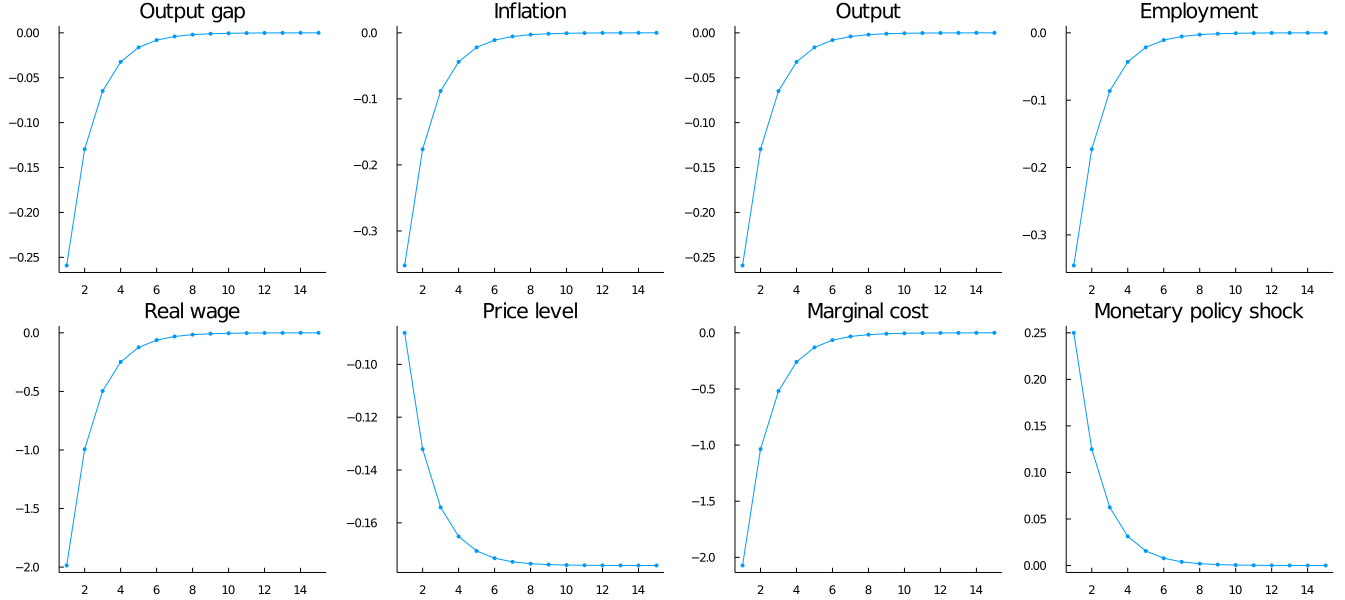

In [15]:
# Display the plots for a monetary policy shock
plot_irfs(compute_IRFs(shocks_monetary_policy, periods))

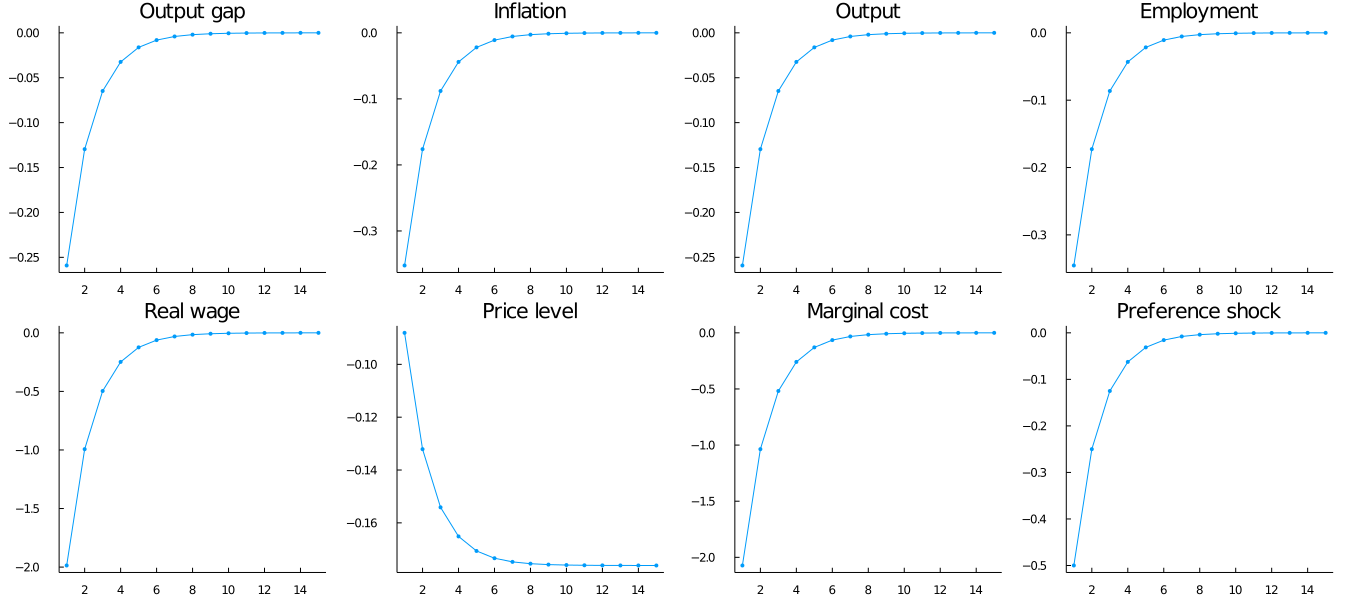

In [17]:
# Display the plots for a preference shock
plot_irfs(compute_IRFs(shocks_discount_rate, periods))